In [1]:
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output

Mounted at /content/drive


## Importing dependencies

In [2]:
!pip3 install -q ktrain
clear_output()

In [3]:
import ktrain
from ktrain import text
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Preprocessing

In [8]:
DATA_PATH = '/content/drive/MyDrive/Colab_Notebooks/NLP_TeamG/datasets/data.csv'

In [9]:
df = pd.read_csv(DATA_PATH)

# remove Chinese data
en = df['content_en']
cn = df['content_cn']
df = df[en != cn]
df = df[['content_en', 'label']]
df = df.sort_values(by='label', ascending=False)
df = df[['content_en', 'label']]
df.label.value_counts()

0    3507
1     303
Name: label, dtype: int64

In [10]:
mini = df[:606]
mini.label.value_counts()

1    303
0    303
Name: label, dtype: int64

In [11]:
X = mini.content_en
y = mini.label

In [12]:
X = df.content_en
y = df.label

In [13]:
X, y = shuffle(X, y, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(X, y)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

## Create a Transformer Model

In [14]:
MODEL_NAME = 'distilbert-base-uncased'
classes = y.unique()
t = text.Transformer(MODEL_NAME, maxlen=500, classes=classes)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:414: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')



preprocessing train...
language: en
train sequence lengths:
	mean : 587
	95percentile : 1574
	99percentile : 2503


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 593
	95percentile : 1587
	99percentile : 2471


In [15]:
# learner.lr_find(show_plot=True, max_epoch=4)

TypeError: ignored

In [16]:
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/4
358/358 [==============================] - 204s 540ms/step - loss: 0.1910 - accuracy: 0.9415 - val_loss: 0.0367 - val_accuracy: 0.9874
Epoch 2/4
358/358 [==============================] - 195s 542ms/step - loss: 0.0605 - accuracy: 0.9797 - val_loss: 0.0395 - val_accuracy: 0.9832
Epoch 3/4
358/358 [==============================] - 195s 544ms/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.0151 - val_accuracy: 0.9958
Epoch 4/4
358/358 [==============================] - 195s 543ms/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0127 - val_accuracy: 0.9958


In [17]:
learner.model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


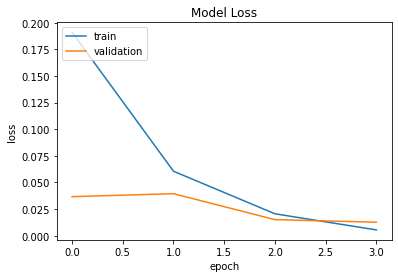

In [18]:
learner.plot()

In [19]:
learner.view_top_losses(n=1, preproc=t)

----------
id:592 | loss:3.19 | true:1 | pred:0)



In [20]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [21]:
print(predictor.predict('He likes money laundering.'))
print(predictor.predict_proba('He likes money laundering.'))

1
[0.15602127 0.8439787 ]


In [22]:
print(predictor.predict('money laundering.'))
print(predictor.predict_proba('money laundering.'))

1
[0.18025132 0.8197487 ]


In [23]:
print(predictor.predict('money.'))
print(predictor.predict_proba('money.'))

0
[0.8121017  0.18789832]


In [24]:
print(predictor.predict('laundering.'))
print(predictor.predict_proba('laundering.'))

0
[0.63831216 0.36168778]


In [25]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [26]:
predictor.explain('Increased scrutiny by regulators is driving a global increase in the number and value of anti-money laundering penalties issued to financial institutions. Financial institutions worldwide are subsequently taking steps to mitigate the risk of receiving anti-money laundering fines from regulators through preventing exposure to sanctioned parties and ensuring anti-money laundering compliance.')